In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


# Reading

In [12]:
calender = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv")
sample_submission = pd.read_csv("../input/m5-forecasting-accuracy/sample_submission.csv")
sell_prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv")
sales_train_validation = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv")
sales_train_evaluation = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_evaluation.csv")

# Dataset Description

Borrowed from [M5-Forecasting : EDA 📈 +LSTM Pytorch Modeling🔥](www.kaggle.com/gopidurgaprasad/m5-forecasting-eda)

# File 1: calendar.csv
Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.

1. date: The date in a “y-m-d” format.
2. wm_yr_wk: The id of the week the date belongs to.
3. weekday: The type of the day (Saturday, Sunday, ..., Friday).
4. wday: The id of the weekday, starting from Saturday.
5. month: The month of the date.
6. year: The year of the date.
7. event_name_1: If the date includes an event, the name of this event.
8. event_type_1: If the date includes an event, the type of this event.
9. event_name_2: If the date includes a second event, the name of this event.
10. event_type_2: If the date includes a second event, the type of this event.
11. snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP 3 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

# File 2: sales_train_validation.csv
Contains the historical daily unit sales data per product and store [d_1 - d_1913].

1. item_id: The id of the product.
2. dept_id: The id of the department the product belongs to.
3. cat_id: The id of the category the product belongs to.
4. store_id: The id of the store where the product is sold.
5. state_id: The State where the store is located.
6. d_1, d_2, ..., d_i, ... d_1941: The number of units sold at day i, starting from 2011-01-29.

# File 3: sell_prices.csv
Contains information about the price of the products sold per store and date.

1. store_id: The id of the store where the product is sold.
2. item_id: The id of the product.
3. wm_yr_wk: The id of the week.
4. sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).
# File 4: sample_submission.csv
Demonstrates the correct format for submission to the competition.

Each row contains an id that is a concatenation of an item_id and a store_id, which is either validation (corresponding to the Public leaderboard), or evaluation (corresponding to the Private leaderboard). You are predicting 28 forecast days (F1-F28) of items sold for each row. For the validation rows, this corresponds to d_1914 - d_1941, and for the evaluation rows, this corresponds to d_1942 - d_1969. (Note: a month before the competition close, the ground truth for the validation rows will be provided.)

# File 5: sales_train_evaluation.csv
Available one month before the competition deadline. It will include sales for [d_1 - d_1941].
In this competition, we need to forecast the sales for [d_1942 - d_1969]. These rows form the evaluation set. The rows [d_1914 - d_1941] form the validation set, and the remaining rows form the training set. Now, since we understand the dataset and know what to predict, let us visualize the dataset.



# Load Libraries

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='darkgrid')
from statistics import *
from tabulate import tabulate

In [14]:
import plotly.graph_objects as go

In [15]:
from plotly.subplots import make_subplots

# Calender Dataframe

In [16]:
calender.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [17]:
calender.tail()

date  wm_yr_wk    weekday  wday  month  year       d  \
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
1964           NaN          NaN           NaN          NaN        0        1   
1965           NaN          NaN           NaN          NaN        0        0   
1966           NaN          NaN           NaN          NaN        0        0   
1967           NaN          NaN           NaN          NaN        0        0   
1968  NBAFinalsEnd     Sporting  Father's day     Cultural        0        0   

      snap_WI  
1964        1  
1965        0  
1966        0  
1967        0  
1968        0

In [18]:
# Display information about each column in calender.
calender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [19]:
# Number of rows and columns for calender.
calender.shape

(1969, 14)

In [20]:
# Check for missing values.
calender.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

# Sell Price Dataframe

In [21]:
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [22]:
sell_prices.tail()

store_id      item_id  wm_yr_wk  sell_price
6841116     WI_3  FOODS_3_827     11617         1.0
6841117     WI_3  FOODS_3_827     11618         1.0
6841118     WI_3  FOODS_3_827     11619         1.0
6841119     WI_3  FOODS_3_827     11620         1.0
6841120     WI_3  FOODS_3_827     11621         1.0

In [23]:
# Display information about each column in sell_prices.
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [24]:
# Number of rows and columns for sell_prices.
sell_prices.shape

(6841121, 4)

In [25]:
# Check for missing values.
sell_prices.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

# sample_submission Dataframe

In [26]:
# Display the first few rows of sample_submission.
sample_submission.head()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
0  HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
1  HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
2  HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
3  HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
4  HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   

   F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
0    0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0    0  

[5 rows x 29 columns]

In [27]:
# Display the last few rows of sample_submission.
sample_submission.tail()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
60975  FOODS_3_823_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60976  FOODS_3_824_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60977  FOODS_3_825_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60978  FOODS_3_826_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60979  FOODS_3_827_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   

       F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
60975    0    0    0    0    0    0    0    0    0    0  
60976    0    0    0    0    0    0    0    0    0    0  
60977    0    0    0    0    0    0    0    0    0    0  
60978    0    0    0    0    0    0    0    0    0    0  
60979    0    0    0    0    0    0    0    0    0    0  

[5 rows x 29 columns]

In [28]:
# Display the info of sample_submission.
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60980 entries, 0 to 60979
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60980 non-null  object
 1   F1      60980 non-null  int64 
 2   F2      60980 non-null  int64 
 3   F3      60980 non-null  int64 
 4   F4      60980 non-null  int64 
 5   F5      60980 non-null  int64 
 6   F6      60980 non-null  int64 
 7   F7      60980 non-null  int64 
 8   F8      60980 non-null  int64 
 9   F9      60980 non-null  int64 
 10  F10     60980 non-null  int64 
 11  F11     60980 non-null  int64 
 12  F12     60980 non-null  int64 
 13  F13     60980 non-null  int64 
 14  F14     60980 non-null  int64 
 15  F15     60980 non-null  int64 
 16  F16     60980 non-null  int64 
 17  F17     60980 non-null  int64 
 18  F18     60980 non-null  int64 
 19  F19     60980 non-null  int64 
 20  F20     60980 non-null  int64 
 21  F21     60980 non-null  int64 
 22  F22     60980 non-null

# Sales Dataframe

In [29]:
sales_train_validation.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [30]:
sales_train_validation.tail()

id      item_id  dept_id cat_id store_id  \
30485  FOODS_3_823_WI_3_validation  FOODS_3_823  FOODS_3  FOODS     WI_3   
30486  FOODS_3_824_WI_3_validation  FOODS_3_824  FOODS_3  FOODS     WI_3   
30487  FOODS_3_825_WI_3_validation  FOODS_3_825  FOODS_3  FOODS     WI_3   
30488  FOODS_3_826_WI_3_validation  FOODS_3_826  FOODS_3  FOODS     WI_3   
30489  FOODS_3_827_WI_3_validation  FOODS_3_827  FOODS_3  FOODS     WI_3   

      state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  \
30485       WI    0    0    2    2  ...       2       0       0       0   
30486       WI    0    0    0    0  ...       0       0       0       0   
30487       WI    0    6    0    2  ...       2       1       0       2   
30488       WI    0    0    0    0  ...       0       0       1       0   
30489       WI    0    0    0    0  ...       0       0       0       0   

       d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
30485       0       0       1       0       0       1  
30486       0       0       0       0       1       0  
30487       0       1       0       0       1       0  
30488       0       1       0       3       1       3  
30489       0       0       0       0       0       0  

[5 rows x 1919 columns]

In [31]:
# Display information about each column in sales_train_validation.
sales_train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [32]:
# Display the information of each column of sales_train_validation.
sales_train_validation.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object

In [33]:
# Display the number of rows and columns for sales_train_validation.
sales_train_validation.shape

(30490, 1919)

In [34]:
# Check for missing values.
sales_train_validation.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [35]:
sales_train_validation.state_id.unique()

array(['CA', 'TX', 'WI'], dtype=object)

# df -> We will consider only WI state_id

In [36]:
df = sales_train_validation[sales_train_validation.state_id == 'WI']

In [37]:
df.shape

(9147, 1919)

In [38]:
df.reset_index(drop=True,inplace=True)

In [39]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       WI    0    0    0    0  ...       0       0       0       0       0   
1       WI    0    0    0    0  ...       1       1       2       0       0   
2       WI    0    0    0    0  ...       0       0       2       1       1   
3       WI    2    1    0    0  ...       0       1       0       0       1   
4       WI    0    0    0    0  ...       0       2       0       1       0   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       0       1       2       1       1  
1       2       2       0       0       2  
2       0       1       1       0       1  
3       0       0       2       1       0  
4       3       1       1       2       1  

[5 rows x 1919 columns]

In [40]:
df.tail()

id      item_id  dept_id cat_id store_id  \
9142  FOODS_3_823_WI_3_validation  FOODS_3_823  FOODS_3  FOODS     WI_3   
9143  FOODS_3_824_WI_3_validation  FOODS_3_824  FOODS_3  FOODS     WI_3   
9144  FOODS_3_825_WI_3_validation  FOODS_3_825  FOODS_3  FOODS     WI_3   
9145  FOODS_3_826_WI_3_validation  FOODS_3_826  FOODS_3  FOODS     WI_3   
9146  FOODS_3_827_WI_3_validation  FOODS_3_827  FOODS_3  FOODS     WI_3   

     state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  \
9142       WI    0    0    2    2  ...       2       0       0       0   
9143       WI    0    0    0    0  ...       0       0       0       0   
9144       WI    0    6    0    2  ...       2       1       0       2   
9145       WI    0    0    0    0  ...       0       0       1       0   
9146       WI    0    0    0    0  ...       0       0       0       0   

      d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
9142       0       0       1       0       0       1  
9143       0       0       0       0       1       0  
9144       0       1       0       0       1       0  
9145       0       1       0       3       1       3  
9146       0       0       0       0       0       0  

[5 rows x 1919 columns]

In [41]:
df.isna().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [42]:
df.item_id.value_counts()

FOODS_3_378        3
FOODS_3_329        3
FOODS_3_760        3
FOODS_2_018        3
HOBBIES_1_153      3
                  ..
FOODS_2_260        3
FOODS_1_113        3
FOODS_3_511        3
HOUSEHOLD_2_221    3
HOBBIES_1_078      3
Name: item_id, Length: 3049, dtype: int64

In [43]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

In [44]:
df.shape

(9147, 1919)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9147 entries, 0 to 9146
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 133.9+ MB


In [46]:
df.nunique()

id          9147
item_id     3049
dept_id        7
cat_id         3
store_id       3
            ... 
d_1909        40
d_1910        44
d_1911        47
d_1912        54
d_1913        48
Length: 1919, dtype: int64

# Analysis

# Categories Wise Product Distribution

In [47]:
categories = list(set(df['cat_id']))
print("Among 9147 products, the categories are ",categories)
sub_categories=list(set(df['dept_id']))
for n,cat_name in enumerate(categories,1):
  d = df[df['cat_id']==cat_name]
  a=d['cat_id'].value_counts()[0]
  print(n,cat_name,"products",a)
  for sub_cat_name in sub_categories:
    if cat_name in sub_cat_name:
      t = d[d['dept_id']==sub_cat_name]
      ji=t['dept_id'].value_counts()[0]
      print("-->",sub_cat_name,ji)
  print("-----------------------")

Among 9147 products, the categories are  ['HOBBIES', 'FOODS', 'HOUSEHOLD']
1 HOBBIES products 1695
--> HOBBIES_1 1248
--> HOBBIES_2 447
-----------------------
2 FOODS products 4311
--> FOODS_1 648
--> FOODS_3 2469
--> FOODS_2 1194
-----------------------
3 HOUSEHOLD products 3141
--> HOUSEHOLD_1 1596
--> HOUSEHOLD_2 1545
-----------------------


# Display the total sales as percentages for each store.

In [48]:
# Create a variable for dates.
date_col = [col for col in df if col.startswith('d_')]

In [49]:
# Sum the sales to create a new column called sales.
df['total_sales'] = df[date_col].sum(axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       WI    0    0    0    0  ...       0       0       0       0       0   
1       WI    0    0    0    0  ...       1       2       0       0       2   
2       WI    0    0    0    0  ...       0       2       1       1       0   
3       WI    2    1    0    0  ...       1       0       0       1       0   
4       WI    0    0    0    0  ...       2       0       1       0       3   

   d_1910  d_1911  d_1912  d_1913  total_sales  
0       1       2       1       1          178  
1       2       0       0       2         1143  
2       1       1       0       1          176  
3       0       2       1       0          905  
4       1       1       2       1         1324  

[5 rows x 1920 columns]

In [51]:

df.groupby('store_id').agg({'total_sales':'sum'})/df.total_sales.sum() * 100

total_sales
store_id             
WI_1        28.415115
WI_2        36.113151
WI_3        35.471735

# Function for Univariate analysis

In [52]:
def univariate_categorical(df,x):
       
    print('\nNumber of unique values => ' + str(len(df[x].unique())) + '\n\n')

    plt.figure(figsize=(10, 10))
    
    y = "count"
    plt.subplot(2, 1, 1)
    plt.xticks(rotation=90)

    sns.countplot(df[x])
    count_df = df[x].value_counts().rename(y).reset_index().rename(columns={"index":x})
    y = "percent(%)"
    percent_df = df[x].value_counts(normalize=True).rename(y).reset_index().rename(columns={"index":x})
    plt.subplot(2, 1, 2)
    sns.barplot(percent_df[x], percent_df[y], data=percent_df)
    plt.xticks(rotation=90)
    plt.show()
    print(tabulate(pd.merge(percent_df, count_df, how='inner'), headers='keys', tablefmt='fancy_grid'))


# Distribution of departments


Number of unique values => 7




/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


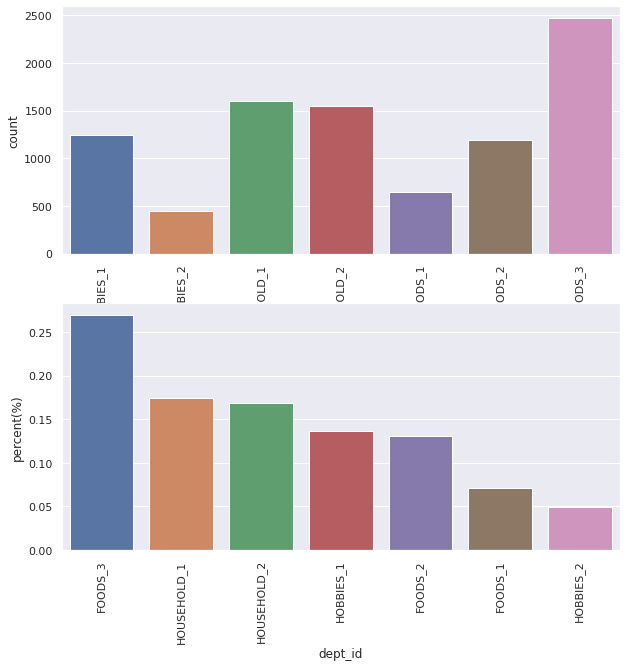

╒════╤═════════════╤══════════════╤═════════╕
│    │ dept_id     │   percent(%) │   count │
╞════╪═════════════╪══════════════╪═════════╡
│  0 │ FOODS_3     │    0.269925  │    2469 │
├────┼─────────────┼──────────────┼─────────┤
│  1 │ HOUSEHOLD_1 │    0.174483  │    1596 │
├────┼─────────────┼──────────────┼─────────┤
│  2 │ HOUSEHOLD_2 │    0.168908  │    1545 │
├────┼─────────────┼──────────────┼─────────┤
│  3 │ HOBBIES_1   │    0.136438  │    1248 │
├────┼─────────────┼──────────────┼─────────┤
│  4 │ FOODS_2     │    0.130535  │    1194 │
├────┼─────────────┼──────────────┼─────────┤
│  5 │ FOODS_1     │    0.0708429 │     648 │
├────┼─────────────┼──────────────┼─────────┤
│  6 │ HOBBIES_2   │    0.0488685 │     447 │
╘════╧═════════════╧══════════════╧═════════╛


In [53]:
univariate_categorical(df,'dept_id')

# Display the total sales as percentages for each department.


In [54]:
df.groupby('dept_id').agg({'total_sales':'sum'})/df.total_sales.sum() * 100

total_sales
dept_id                 
FOODS_1         7.927225
FOODS_2        13.823469
FOODS_3        49.643372
HOBBIES_1       7.519595
HOBBIES_2       0.717201
HOUSEHOLD_1    16.860236
HOUSEHOLD_2     3.508902

# Distribution of products categories


Number of unique values => 3




/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


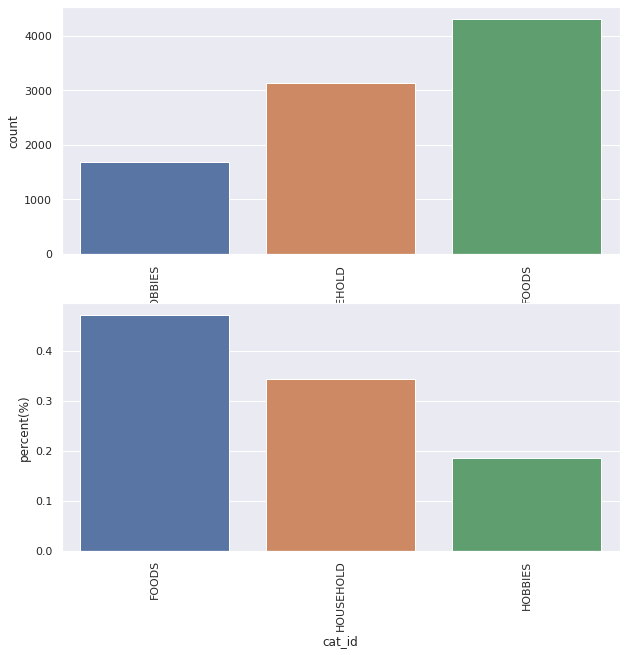

╒════╤═══════════╤══════════════╤═════════╕
│    │ cat_id    │   percent(%) │   count │
╞════╪═══════════╪══════════════╪═════════╡
│  0 │ FOODS     │     0.471302 │    4311 │
├────┼───────────┼──────────────┼─────────┤
│  1 │ HOUSEHOLD │     0.343391 │    3141 │
├────┼───────────┼──────────────┼─────────┤
│  2 │ HOBBIES   │     0.185307 │    1695 │
╘════╧═══════════╧══════════════╧═════════╛


In [55]:
univariate_categorical(df,'cat_id')

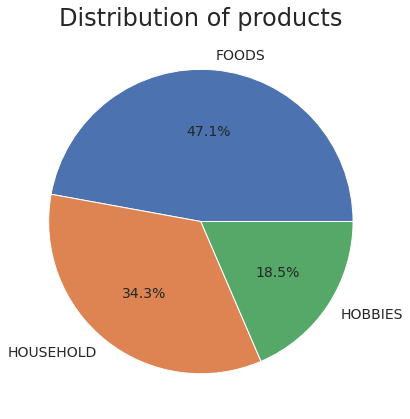

In [56]:
sub_categories=df['cat_id'].value_counts()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.pie(x=sub_categories.values,
       labels=sub_categories.index,
       autopct='%1.1f%%',
       textprops={'fontsize': 14})
ax.set_title('Distribution of products',fontdict={'fontsize':24})
plt.show()

# Display the total sales for each category.

In [57]:

df.groupby('cat_id').agg({'total_sales':'sum'}).reset_index()

cat_id  total_sales
0      FOODS     12937216
1    HOBBIES      1492578
2  HOUSEHOLD      3691062

# Display the total sales as percentages for each category.

In [58]:

df.groupby('cat_id').agg({'total_sales':'sum'})/df.total_sales.sum() * 100

total_sales
cat_id                
FOODS        71.394067
HOBBIES       8.236796
HOUSEHOLD    20.369137

# Plot the total sales for categories by Store

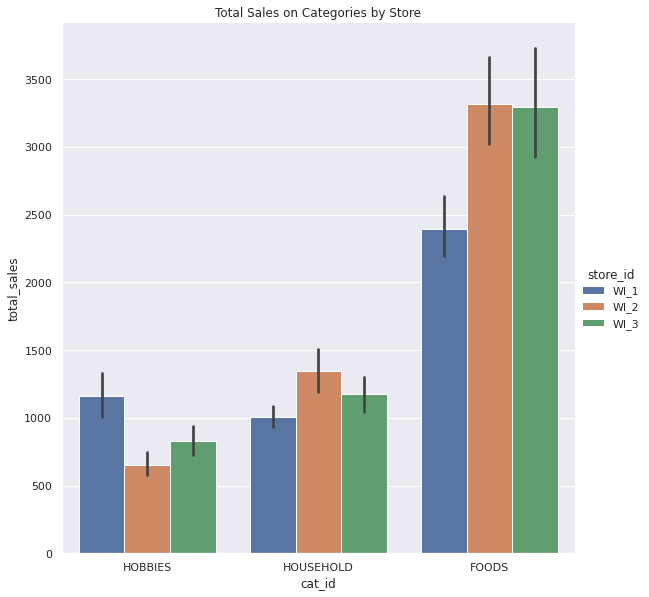

In [59]:
sns.catplot(x='cat_id', y='total_sales',
           hue='store_id',
           data=df, kind='bar',
           height=8, aspect=1)
plt.title('Total Sales on Categories by Store')
plt.show()

# Distribution of stores 


Number of unique values => 3




/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


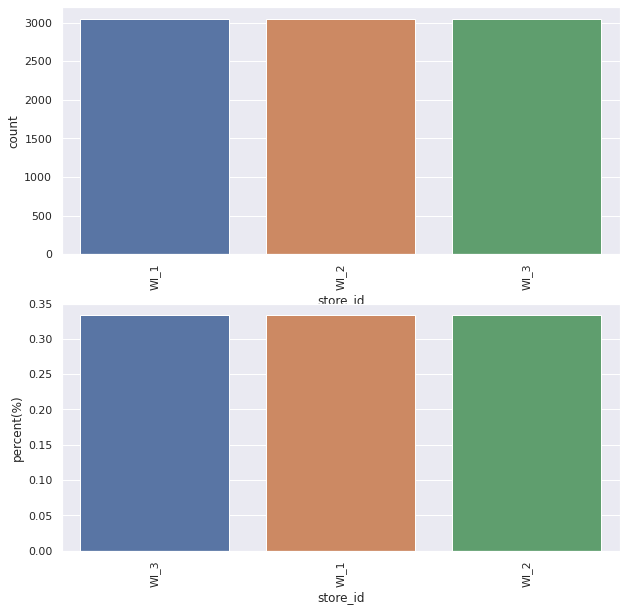

╒════╤════════════╤══════════════╤═════════╕
│    │ store_id   │   percent(%) │   count │
╞════╪════════════╪══════════════╪═════════╡
│  0 │ WI_3       │     0.333333 │    3049 │
├────┼────────────┼──────────────┼─────────┤
│  1 │ WI_1       │     0.333333 │    3049 │
├────┼────────────┼──────────────┼─────────┤
│  2 │ WI_2       │     0.333333 │    3049 │
╘════╧════════════╧══════════════╧═════════╛


In [60]:
univariate_categorical(df,"store_id")

# Distribution of Mean Sales By Store

In [61]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911',
       'd_1912', 'd_1913', 'total_sales'],
      dtype='object', length=1920)

In [62]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       WI    0    0    0    0  ...       0       0       0       0       0   
1       WI    0    0    0    0  ...       1       2       0       0       2   
2       WI    0    0    0    0  ...       0       2       1       1       0   
3       WI    2    1    0    0  ...       1       0       0       1       0   
4       WI    0    0    0    0  ...       2       0       1       0       3   

   d_1910  d_1911  d_1912  d_1913  total_sales  
0       1       2       1       1          178  
1       2       0       0       2         1143  
2       1       1       0       1          176  
3       0       2       1       0          905  
4       1       1       2       1         1324  

[5 rows x 1920 columns]

In [63]:
sales_d = df.drop(['state_id','store_id','cat_id','dept_id','item_id'], axis=1)

In [64]:
sales_d.head()

id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  \
0  HOBBIES_1_001_WI_1_validation    0    0    0    0    0    0    0    0    0   
1  HOBBIES_1_002_WI_1_validation    0    0    0    0    0    0    0    0    0   
2  HOBBIES_1_003_WI_1_validation    0    0    0    0    0    0    0    0    0   
3  HOBBIES_1_004_WI_1_validation    2    1    0    0    0    2    1    1    0   
4  HOBBIES_1_005_WI_1_validation    0    0    0    0    0    0    0    0    0   

   ...  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  d_1911  d_1912  \
0  ...       0       0       0       0       0       1       2       1   
1  ...       1       2       0       0       2       2       0       0   
2  ...       0       2       1       1       0       1       1       0   
3  ...       1       0       0       1       0       0       2       1   
4  ...       2       0       1       0       3       1       1       2   

   d_1913  total_sales  
0       1          178  
1       2         1143  
2       1          176  
3       0          905  
4       1         1324  

[5 rows x 1915 columns]

In [65]:
calender.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [66]:
calender.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')

In [67]:
sales_p = sales_d.set_index('id').T.merge(calender.set_index('d')['date'],
                                                 left_index=True,
                                                 right_index=True,
                                                  validate='1:1') 


In [68]:
sales_p

HOBBIES_1_001_WI_1_validation  HOBBIES_1_002_WI_1_validation  \
d_1                                 0                              0   
d_2                                 0                              0   
d_3                                 0                              0   
d_4                                 0                              0   
d_5                                 0                              0   
...                               ...                            ...   
d_1909                              0                              2   
d_1910                              1                              2   
d_1911                              2                              0   
d_1912                              1                              0   
d_1913                              1                              2   

        HOBBIES_1_003_WI_1_validation  HOBBIES_1_004_WI_1_validation  \
d_1                                 0                              2   
d_2                                 0                              1   
d_3                                 0                              0   
d_4                                 0                              0   
d_5                                 0                              0   
...                               ...                            ...   
d_1909                              0                              0   
d_1910                              1                              0   
d_1911                              1                              2   
d_1912                              0                              1   
d_1913                              1                              0   

        HOBBIES_1_005_WI_1_validation  HOBBIES_1_006_WI_1_validation  \
d_1                                 0                              0   
d_2                                 0                              0   
d_3                                 0                              0   
d_4                                 0                              0   
d_5                                 0                              0   
...                               ...                            ...   
d_1909                              3                              3   
d_1910                              1                              6   
d_1911                              1                              0   
d_1912                              2                              1   
d_1913                              1                              2   

        HOBBIES_1_007_WI_1_validation  HOBBIES_1_008_WI_1_validation  \
d_1                                 0                             16   
d_2                                 0                              2   
d_3                                 0                              2   
d_4                                 0                              2   
d_5                                 0                              0   
...                               ...                            ...   
d_1909                              1                              4   
d_1910                              1                              7   
d_1911                              0                              2   
d_1912                              2                              4   
d_1913                              0                              8   

        HOBBIES_1_009_WI_1_validation  HOBBIES_1_010_WI_1_validation  ...  \
d_1                                 0                              1  ...   
d_2                                 0                              2  ...   
d_3                                 0                              0  ...   
d_4                                 0                              0  ...   
d_5                                 0                              0  ...   
...                               ...                            ...  ...   
d_1909   

In [69]:
sales_p = sales_p.set_index('date')

In [70]:
sales_p

HOBBIES_1_001_WI_1_validation  HOBBIES_1_002_WI_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   
...                                   ...                            ...   
2016-04-20                              0                              2   
2016-04-21                              1                              2   
2016-04-22                              2                              0   
2016-04-23                              1                              0   
2016-04-24                              1                              2   

            HOBBIES_1_003_WI_1_validation  HOBBIES_1_004_WI_1_validation  \
date                                                                       
2011-01-29                              0                              2   
2011-01-30                              0                              1   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   
...                                   ...                            ...   
2016-04-20                              0                              0   
2016-04-21                              1                              0   
2016-04-22                              1                              2   
2016-04-23                              0                              1   
2016-04-24                              1                              0   

            HOBBIES_1_005_WI_1_validation  HOBBIES_1_006_WI_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   
...                                   ...                            ...   
2016-04-20                              3                              3   
2016-04-21                              1                              6   
2016-04-22                              1                              0   
2016-04-23                              2                              1   
2016-04-24                              1                              2   

            HOBBIES_1_007_WI_1_validation  HOBBIES_1_008_WI_1_validation  \
date                                                                       
2011-01-29                              0                             16   
2011-01-30                              0                              2   
2011-01-31                              0                              2   
2011-02-01                              0                              2   
2011-02-02                              0                              0   
...                                   ...                            ...   
2016-04-20                              1                              4   
2016-04-21                              1                              7   
2016-04-22                              0                              2   
2016-04-23                              2                              4   
2016-04-24                              0                              8   

            HOBBIES_1_009_WI_1_validation  HOBBIES_1_010

In [71]:
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [72]:
stores = sorted(set(sell_prices['store_id']))

In [73]:
stores

['CA_1',
 'CA_2',
 'CA_3',
 'CA_4',
 'TX_1',
 'TX_2',
 'TX_3',
 'WI_1',
 'WI_2',
 'WI_3']

In [74]:
stores = [
 'WI_1',
 'WI_2',
 'WI_3']

In [75]:
Means=[]
for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)
 
  Means.append(np.mean(sales_p[store_items].sum(axis=1)))

In [76]:
Means

[2691.6163094615786, 3420.811291165708, 3360.0533193936226]

In [77]:
data = np.transpose([Means, stores])
df_mean = pd.DataFrame(data, columns=["Mean sales", "Stores"])

In [78]:
data

array([['2691.6163094615786', 'WI_1'],
       ['3420.811291165708', 'WI_2'],
       ['3360.0533193936226', 'WI_3']], dtype='<U32')

In [79]:
df_mean

Mean sales Stores
0  2691.6163094615786   WI_1
1   3420.811291165708   WI_2
2  3360.0533193936226   WI_3

In [80]:
df_mean ['mean_sale'] = df_mean ['Mean sales'].astype (float)

In [81]:
df_mean

Mean sales Stores    mean_sale
0  2691.6163094615786   WI_1  2691.616309
1   3420.811291165708   WI_2  3420.811291
2  3360.0533193936226   WI_3  3360.053319

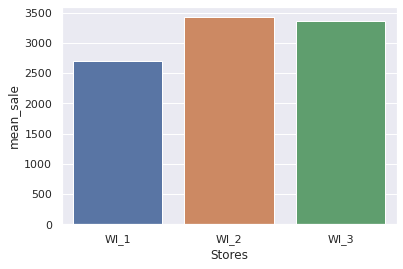

In [82]:
ax.set_title( "Stores vs Mean sales" , size = 24 )
ax = sns.barplot(x="Stores", y="mean_sale", data=df_mean)


Observations

1. WI_2 stores have highest mean sales among all the stores
2. Store W1_1 has minimum sales.

In [83]:
stores

['WI_1', 'WI_2', 'WI_3']

In [84]:
sales_p.columns

Index(['HOBBIES_1_001_WI_1_validation', 'HOBBIES_1_002_WI_1_validation',
       'HOBBIES_1_003_WI_1_validation', 'HOBBIES_1_004_WI_1_validation',
       'HOBBIES_1_005_WI_1_validation', 'HOBBIES_1_006_WI_1_validation',
       'HOBBIES_1_007_WI_1_validation', 'HOBBIES_1_008_WI_1_validation',
       'HOBBIES_1_009_WI_1_validation', 'HOBBIES_1_010_WI_1_validation',
       ...
       'FOODS_3_818_WI_3_validation', 'FOODS_3_819_WI_3_validation',
       'FOODS_3_820_WI_3_validation', 'FOODS_3_821_WI_3_validation',
       'FOODS_3_822_WI_3_validation', 'FOODS_3_823_WI_3_validation',
       'FOODS_3_824_WI_3_validation', 'FOODS_3_825_WI_3_validation',
       'FOODS_3_826_WI_3_validation', 'FOODS_3_827_WI_3_validation'],
      dtype='object', length=9147)

# Rolling Average Sells

In [85]:

name=["Rolling Average Sales vs. Time (per store) with window size:7",
      "Rolling Average Sales vs. Time (per store) with window size:10",
      "Rolling Average Sales vs. Time (per store) with window size:13",
      "Rolling Average Sales vs. Time (per store) with window size:30",
      "Rolling Average Sales vs. Time (per store) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).mean()
  l=np.arange(len(data))
  fig.add_trace(go.Scatter(x=l, y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()

In [86]:
name=["Rolling Average Sales vs. Time(Box_plot_visualization) with window size:7",
      "Rolling Average Sales vs. Time(Box_plot_visualization) with window size:10",
      "Rolling Average Sales vs. Time(Box_plot_visualization) with window size:13",
      "Rolling Average Sales vs. Time(Box_plot_visualization) with window size:30",
      "Rolling Average Sales vs. Time(Box_plot_visualization) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).mean()
  fig.add_trace(go.Box(x=[store]*len(data), y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()


Observations

1. Every rolling mean sales curve has 'linear osciallation' trend and also have upward linear trend.
2. WI_2 has the highest sell.
3. WI stores do not have much variance which may implies that development is uniform in the WI state.

# Rolling Medians Sales

In [87]:
name=["Rolling Medians Sales vs. Time (per store) with window size:7",
      "Rolling Medians Sales vs. Time (per store) with window size:10",
      "Rolling Medians Sales vs. Time (per store) with window size:13",
      "Rolling Medians Sales vs. Time (per store) with window size:30",
      "Rolling Medians Sales vs. Time (per store) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).median()
  l=np.arange(len(data))
  fig.add_trace(go.Scatter(x=l, y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()

In [88]:
name=["Rolling Medians Sales vs. Time(Box_plot_visualization) with window size:7",
      "Rolling Medians Sales vs. Time(Box_plot_visualization) with window size:10",
      "Rolling Medians Sales vs. Time(Box_plot_visualization) with window size:13",
      "Rolling Medians Sales vs. Time(Box_plot_visualization) with window size:30",
      "Rolling Medians Sales vs. Time(Box_plot_visualization) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).median()
  fig.add_trace(go.Box(x=[store]*len(data), y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()

Observations
1. Took rolling medians for different window size ie. 7,10,13,30 and 90.The observations are quite similar to rolling averages.

# Rolling Minimums Sales

In [89]:
name=["Rolling Minimums Sales vs. Time (per store) with window size:7",
      "Rolling Minimums Sales vs. Time (per store) with window size:10",
      "Rolling Minimums Sales vs. Time (per store) with window size:13",
      "Rolling Minimums Sales vs. Time (per store) with window size:30",
      "Rolling Minimums Sales vs. Time (per store) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).min()

  l=np.arange(len(data))
  fig.add_trace(go.Scatter(x=l, y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()
 

In [90]:
name=["Rolling Minimums Sales vs. Time(Box_plot_visualization) with window size:7",
      "Rolling Minimums Sales vs. Time(Box_plot_visualization) with window size:10",
      "Rolling Minimums Sales vs. Time(Box_plot_visualization) with window size:13",
      "Rolling Minimums Sales vs. Time(Box_plot_visualization) with window size:30",
      "Rolling Minimums Sales vs. Time(Box_plot_visualization) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).min()
  fig.add_trace(go.Box(x=[store]*len(data), y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()

Observations
1. Took rolling minimums for different window size ie. 7,10,13,30 and 90. The observations are quite similar to rolling averages.


# Rolling Maximums Sales

In [91]:
name=["Rolling Maximums Sales vs. Time (per store) with window size:7",
      "Rolling Maximums Sales vs. Time (per store) with window size:10",
      "Rolling Maximums Sales vs. Time (per store) with window size:13",
      "Rolling Maximums Sales vs. Time (per store) with window size:30",
      "Rolling Maximums Sales vs. Time (per store) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).max()
  l=np.arange(len(data))
  fig.add_trace(go.Scatter(x=l, y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()

In [92]:
name=["Rolling Maximums Sales vs. Time(Box_plot_visualization) with window size:7",
      "Rolling Maximums Sales vs. Time(Box_plot_visualization) with window size:10",
      "Rolling Maximums Sales vs. Time(Box_plot_visualization) with window size:13",
      "Rolling Maximums Sales vs. Time(Box_plot_visualization) with window size:30",
      "Rolling Maximums Sales vs. Time(Box_plot_visualization) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).max()
  fig.add_trace(go.Box(x=[store]*len(data), y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()

Observations
1. Took rolling maximums for different window size ie. 7,10,13,30 and 90. The observations are quite similar to rolling averages.

# Rolling 25th Percentiles Sales

In [93]:
name=["Rolling 25th Percentiles Sales vs. Time (per store) with window size:7",
      "Rolling 25th Percentiles Sales vs. Time (per store) with window size:10",
      "Rolling 25th Percentiles Sales vs. Time (per store) with window size:13",
      "Rolling 25th Percentiles Sales vs. Time (per store) with window size:30",
      "Rolling 25th Percentiles Sales vs. Time (per store) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).apply(lambda x: np.percentile(x,25))
  l=np.arange(len(data))
  fig.add_trace(go.Scatter(x=l, y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()

In [94]:
name=["Rolling 25th Percentiles Sales vs. Time(Box_plot_visualization) with window size:7",
      "Rolling 25th Percentiles Sales vs. Time(Box_plot_visualization) with window size:10",
      "Rolling 25th Percentiles Sales vs. Time(Box_plot_visualization) with window size:13",
      "Rolling 25th Percentiles Sales vs. Time(Box_plot_visualization) with window size:30",
      "Rolling 25th PercentilesSales vs. Time(Box_plot_visualization) with window size:90"]

window_size=[7,10,13,30,90]

for i,j in enumerate(window_size):

 fig = go.Figure()

 for store in stores:
  store_items=[]
  for a in sales_p.columns:
    if store in a:
      store_items.append(a)

  data = sales_p[store_items].sum(axis=1)
  data = data.rolling(j).apply(lambda x: np.percentile(x,25))
  fig.add_trace(go.Box(x=[store]*len(data), y=data, name=store))
  
 fig.update_layout(xaxis_title="Time", yaxis_title="Sales",title=name[i],title_x=0.5)
 fig.show()

Observations
1. Took rolling 25th percentiles for different window size ie. 7,10,13,30 and 90.The observations are quite similar to rolling averages.


Overall Observations

1. The average sales in descending order are WI_2, WI_3, WI_1.
2. WI stores has low disparity in sales and sales curves meet which may show that WI does not have specific 'hubs' of development and there is equity in development across the state.

# items by category

In [95]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       WI    0    0    0    0  ...       0       0       0       0       0   
1       WI    0    0    0    0  ...       1       2       0       0       2   
2       WI    0    0    0    0  ...       0       2       1       1       0   
3       WI    2    1    0    0  ...       1       0       0       1       0   
4       WI    0    0    0    0  ...       2       0       1       0       3   

   d_1910  d_1911  d_1912  d_1913  total_sales  
0       1       2       1       1          178  
1       2       0       0       2         1143  
2       1       1       0       1          176  
3       0       2       1       0          905  
4       1       1       2       1         1324  

[5 rows x 1920 columns]

In [96]:
sales_p.head()

HOBBIES_1_001_WI_1_validation  HOBBIES_1_002_WI_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_003_WI_1_validation  HOBBIES_1_004_WI_1_validation  \
date                                                                       
2011-01-29                              0                              2   
2011-01-30                              0                              1   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_005_WI_1_validation  HOBBIES_1_006_WI_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_007_WI_1_validation  HOBBIES_1_008_WI_1_validation  \
date                                                                       
2011-01-29                              0                             16   
2011-01-30                              0                              2   
2011-01-31                              0                              2   
2011-02-01                              0                              2   
2011-02-02                              0                              0   

            HOBBIES_1_009_WI_1_validation  HOBBIES_1_010_WI_1_validation  ...  \
date                                                                      ...   
2011-01-29                              0                              1  ...   
2011-01-30                              0                              2  ...   
2011-01-31                              0                              0  ...   
2011-02-01                              0                              0  ...   
2011-02-02                              0                              0  ...   

            FOODS_3_818_WI_3_validation  FOODS_3_819_WI_3_validation  \
date                                                                   
2011-01-29                            0                           14   
2011-01-30                            0                           11   
2011-01-31                            0                            5   
2011-02-01                            0                            6   
2011-02-02                            0                            5   

            FOODS_3_820_WI_3_validation  FOODS_3_821_WI_3_validation  \
date                                                                   
2011-01-29                            1                            0   
2011-01-30                            1                            0   
2011-01-31                            1                            0   
2011-02-01                            1                            0   
2011-02-02                            1                            0   

            FOODS_3_822_WI_3_validation  FOODS_3_823_WI_3_validation  \
date                                                                   
2011-01-29                            4                            0   
2011-01-30                            4                            0   
2011-01-31    

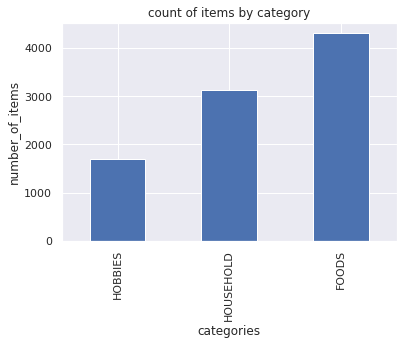

In [97]:
s_g_id=(df.groupby('cat_id').count()['id'])
s_g_id=s_g_id.sort_values()
s_g_id.plot(kind='bar', title='count of items by category')
plt.xlabel("categories")
plt.ylabel("number_of_items")
plt.show()


Number of unique values => 3




/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



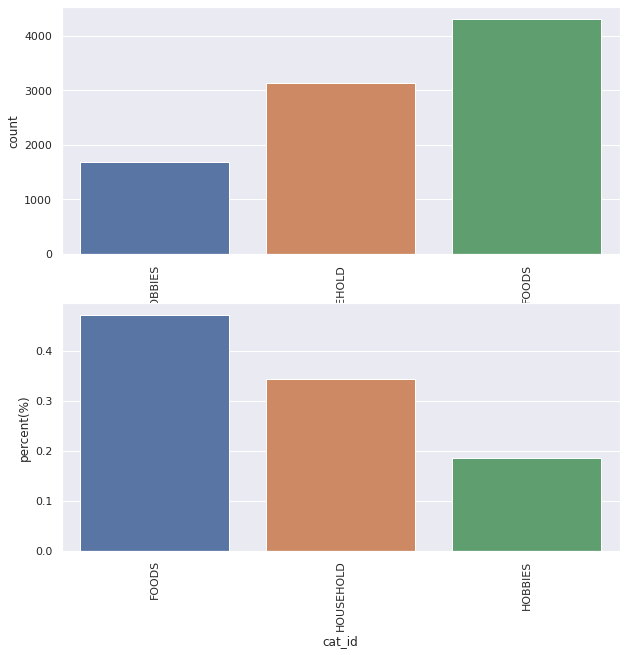

╒════╤═══════════╤══════════════╤═════════╕
│    │ cat_id    │   percent(%) │   count │
╞════╪═══════════╪══════════════╪═════════╡
│  0 │ FOODS     │     0.471302 │    4311 │
├────┼───────────┼──────────────┼─────────┤
│  1 │ HOUSEHOLD │     0.343391 │    3141 │
├────┼───────────┼──────────────┼─────────┤
│  2 │ HOBBIES   │     0.185307 │    1695 │
╘════╧═══════════╧══════════════╧═════════╛


In [98]:
univariate_categorical(df,'cat_id')


Observations

1. FOODS category has the highest number of items.
2. The number of items in descending order are FOODs, HOUSEHOLD and HOBBIES.

# Total Sales by Item category

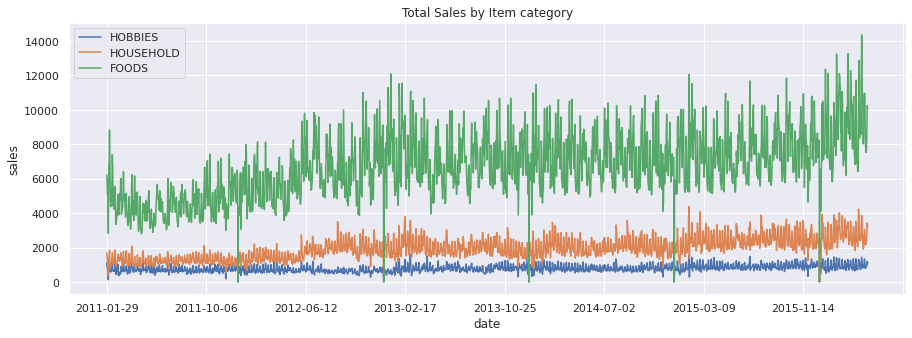

In [99]:
categories=df['cat_id'].unique()

for cat in categories:
  cat_cols=[]
  for c in sales_p.columns:
    if cat in c:
      cat_cols.append(c)
  sales_p[cat_cols].sum(axis=1).plot(figsize=(15, 5), title='Total Sales by Item category')

plt.legend(df['cat_id'].unique())
plt.ylabel("sales")
plt.show()



Observations

1. FOODS category items have maximum number of sales.
2. For some days sale is nearly zero ie. longer spikes in sales curves, which may show that there is a holiday or item is unavailable on that day.
3. there are days with zero sales which is Christmas. I can observe the days before and after Christmas there are higher food sales than other day, and these days are Thanksgiving and the Super Bowl.

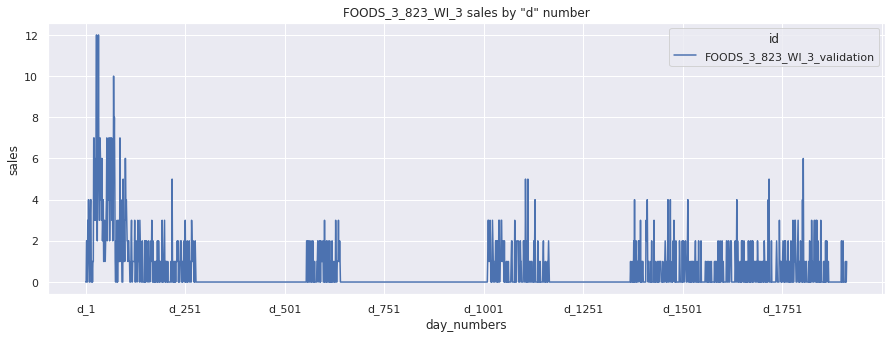

In [100]:
# take a random item that sell a lot and check it's sales curve

# Note there are days where it appears the item is unavailable and sales flatline

d_cols = [c for c in df.columns if 'd_' in c]
sales_f=df.loc[df['id'] == 'FOODS_3_823_WI_3_validation']
sales_f=sales_f.set_index('id')[d_cols].T
sales_f.plot(figsize=(15, 5),
             title='FOODS_3_823_WI_3 sales by "d" number')
plt.xlabel("day_numbers")
plt.ylabel("sales")
plt.show()


Observations

1. Sales curve is very erratic which implies that there are so many factors affect the sales on a given day.
2. For some days sales curve is flatline which means item is unavailable.
3. Item is unavailable for many periods of time.

### Retrieved from:  [M5 Competition : Explore+EDA + Models 📈](https://www.kaggle.com/deepakdeepu8978/m5-competition-explore-eda-models) 

In [101]:
!pip install dabl

     |████████████████████████████████| 558 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 22.3 MB 13.5 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.2 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 0.24.2 which is incompatible.


/opt/conda/lib/python3.7/site-packages/dabl/plot/supervised.py:548: FutureWarning:

The second positional argument of plot is a Series 'y'. If passing a column name, use a keyword.



Target looks like classification
Showing only top 10 of 1909 continuous features


/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:633: UserWarning:

Dropped 38 outliers in column total_sales.

/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:633: UserWarning:

Dropped 28 outliers in column d_1836.

/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:633: UserWarning:

Dropped 24 outliers in column d_1206.

/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:633: UserWarning:

Dropped 23 outliers in column d_1339.

/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:633: UserWarning:

Dropped 38 outliers in column d_1718.

/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:633: UserWarning:

Dropped 26 outliers in column d_1913.

/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:633: UserWarning:

Dropped 18 outliers in column d_1332.

/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:633: UserWarning:

Dropped 27 outliers in column d_1711.

/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:633: User

Linear Discriminant Analysis training set score: 0.621


/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:376: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/conda/lib/python3.7/site-packages/dabl/plot/utils.py:376: UserWarning:

FixedFormatter should only be used together with FixedLocator



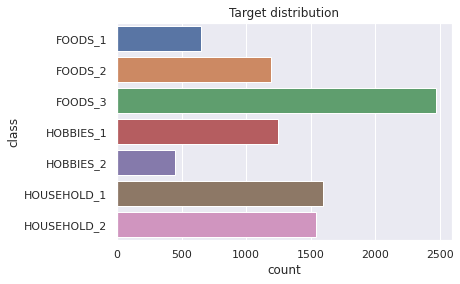

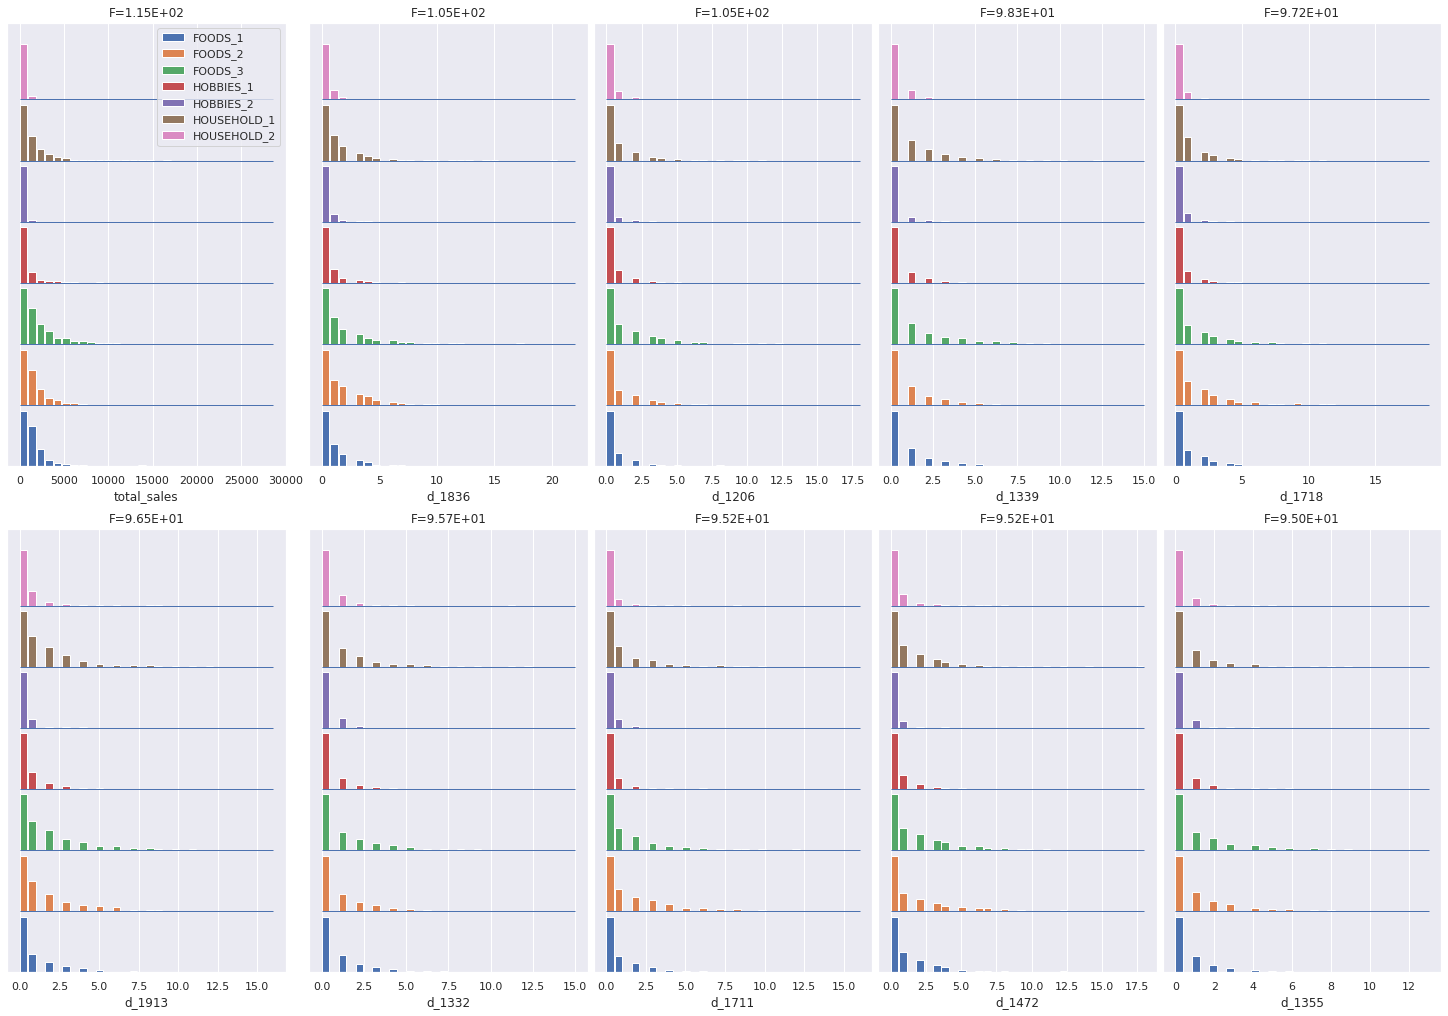

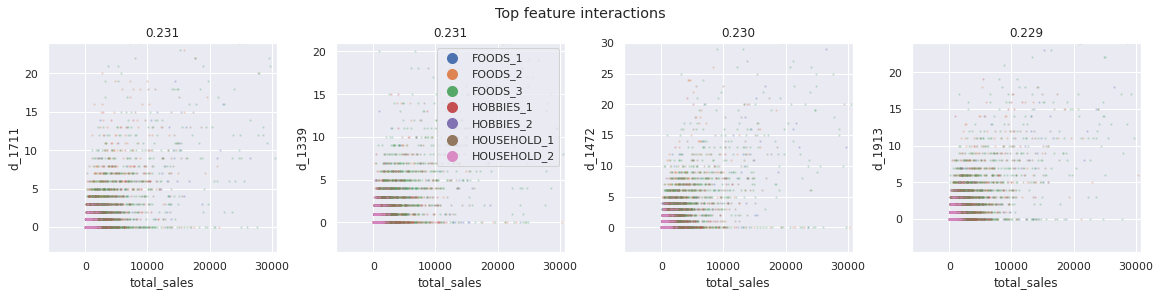

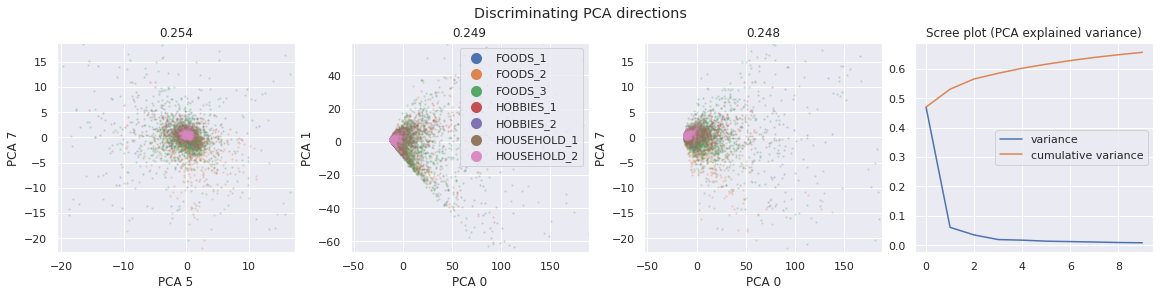

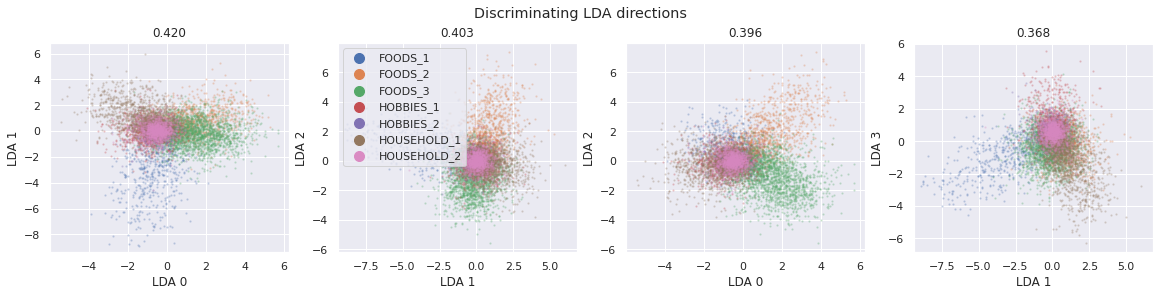

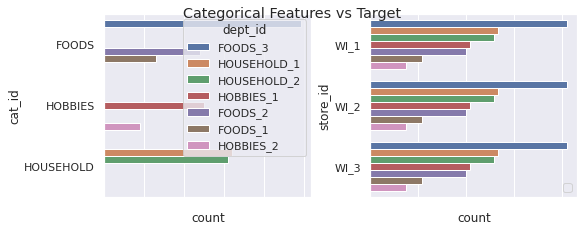

In [102]:

from dabl import plot

plot(df, 'dept_id')
plt.show()

The plots above display the distributions of the features of the dataset and their interactions with each other. This is useful in preparing the data for modeling. The distributions of the features are skewd right and need to be normalized with the standard scaler from scikit learn library before modelling.

# Store WI_1 Analysis

In [103]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911',
       'd_1912', 'd_1913', 'total_sales'],
      dtype='object', length=1920)

In [104]:
df.drop(['total_sales'], axis = 1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

In [106]:
df.shape

(9147, 1919)

In [107]:
# Data preprocessing for EDA.
sales_melt = pd.melt(df, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id',
                                     'state_id'], var_name='day', value_name='demand')

In [108]:
df.shape,sales_melt.shape

((9147, 1919), (17498211, 8))

In [109]:
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       WI    0    0    0    0  ...       0       0       0       0       0   
1       WI    0    0    0    0  ...       1       1       2       0       0   
2       WI    0    0    0    0  ...       0       0       2       1       1   
3       WI    2    1    0    0  ...       0       1       0       0       1   
4       WI    0    0    0    0  ...       0       2       0       1       0   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       0       1       2       1       1  
1       2       2       0       0       2  
2       0       1       1       0       1  
3       0       0       2       1       0  
4       3       1       1       2       1  

[5 rows x 1919 columns]

In [110]:
sales_melt.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  day  demand  
0       WI  d_1       0  
1       WI  d_1       0  
2       WI  d_1       0  
3       WI  d_1       2  
4       WI  d_1       0

In [111]:
sales_melt.tail()

id      item_id  dept_id cat_id store_id  \
17498206  FOODS_3_823_WI_3_validation  FOODS_3_823  FOODS_3  FOODS     WI_3   
17498207  FOODS_3_824_WI_3_validation  FOODS_3_824  FOODS_3  FOODS     WI_3   
17498208  FOODS_3_825_WI_3_validation  FOODS_3_825  FOODS_3  FOODS     WI_3   
17498209  FOODS_3_826_WI_3_validation  FOODS_3_826  FOODS_3  FOODS     WI_3   
17498210  FOODS_3_827_WI_3_validation  FOODS_3_827  FOODS_3  FOODS     WI_3   

         state_id     day  demand  
17498206       WI  d_1913       1  
17498207       WI  d_1913       0  
17498208       WI  d_1913       0  
17498209       WI  d_1913       3  
17498210       WI  d_1913       0

In [112]:
calender.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [113]:
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [114]:

sales_WI_1 = sales_melt[sales_melt.store_id == "WI_1"]
new_WI_1 = pd.merge(sales_WI_1, calender, left_on="day", right_on="d", how="left")
new_WI_1 = pd.merge(new_WI_1, sell_prices, left_on=["store_id", "item_id", "wm_yr_wk"],
                    right_on=["store_id", "item_id", "wm_yr_wk"], how="left")

In [115]:
new_WI_1.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  day  demand        date  wm_yr_wk  ...  year    d  event_name_1  \
0       WI  d_1       0  2011-01-29     11101  ...  2011  d_1           NaN   
1       WI  d_1       0  2011-01-29     11101  ...  2011  d_1           NaN   
2       WI  d_1       0  2011-01-29     11101  ...  2011  d_1           NaN   
3       WI  d_1       2  2011-01-29     11101  ...  2011  d_1           NaN   
4       WI  d_1       0  2011-01-29     11101  ...  2011  d_1           NaN   

   event_type_1 event_name_2 event_type_2 snap_CA snap_TX snap_WI  sell_price  
0           NaN          NaN          NaN       0       0       0         NaN  
1           NaN          NaN          NaN       0       0       0         NaN  
2           NaN          NaN          NaN       0       0       0         NaN  
3           NaN          NaN          NaN       0       0       0        4.34  
4           NaN          NaN          NaN       0       0       0         NaN  

[5 rows x 23 columns]

In [116]:
new_WI_1.tail()

id      item_id  dept_id cat_id store_id  \
5832732  FOODS_3_823_WI_1_validation  FOODS_3_823  FOODS_3  FOODS     WI_1   
5832733  FOODS_3_824_WI_1_validation  FOODS_3_824  FOODS_3  FOODS     WI_1   
5832734  FOODS_3_825_WI_1_validation  FOODS_3_825  FOODS_3  FOODS     WI_1   
5832735  FOODS_3_826_WI_1_validation  FOODS_3_826  FOODS_3  FOODS     WI_1   
5832736  FOODS_3_827_WI_1_validation  FOODS_3_827  FOODS_3  FOODS     WI_1   

        state_id     day  demand        date  wm_yr_wk  ...  year       d  \
5832732       WI  d_1913       0  2016-04-24     11613  ...  2016  d_1913   
5832733       WI  d_1913       1  2016-04-24     11613  ...  2016  d_1913   
5832734       WI  d_1913       2  2016-04-24     11613  ...  2016  d_1913   
5832735       WI  d_1913       2  2016-04-24     11613  ...  2016  d_1913   
5832736       WI  d_1913       0  2016-04-24     11613  ...  2016  d_1913   

         event_name_1  event_type_1 event_name_2 event_type_2 snap_CA snap_TX  \
5832732           NaN           NaN          NaN          NaN       0       0   
5832733           NaN           NaN          NaN          NaN       0       0   
5832734           NaN           NaN          NaN          NaN       0       0   
5832735           NaN           NaN          NaN          NaN       0       0   
5832736           NaN           NaN          NaN          NaN       0       0   

        snap_WI  sell_price  
5832732       0        2.98  
5832733       0        2.48  
5832734       0        3.98  
5832735       0        1.28  
5832736       0        1.00  

[5 rows x 23 columns]

In [117]:

new_WI_1["day_int"] = new_WI_1.day.apply(lambda x: int(x.split("_")[-1]))

new_WI_1.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  day  demand        date  wm_yr_wk  ...    d  event_name_1  \
0       WI  d_1       0  2011-01-29     11101  ...  d_1           NaN   
1       WI  d_1       0  2011-01-29     11101  ...  d_1           NaN   
2       WI  d_1       0  2011-01-29     11101  ...  d_1           NaN   
3       WI  d_1       2  2011-01-29     11101  ...  d_1           NaN   
4       WI  d_1       0  2011-01-29     11101  ...  d_1           NaN   

   event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI sell_price  \
0           NaN           NaN          NaN       0       0       0        NaN   
1           NaN           NaN          NaN       0       0       0        NaN   
2           NaN           NaN          NaN       0       0       0        NaN   
3           NaN           NaN          NaN       0       0       0       4.34   
4           NaN           NaN          NaN       0       0       0        NaN   

   day_int  
0        1  
1        1  
2        1  
3        1  
4        1  

[5 rows x 24 columns]

In [118]:
# Demand each day for store WI_1.
day_sum = new_WI_1.groupby("day_int")[["sell_price", "demand"]].agg("sum").reset_index()

In [119]:
day_sum

day_int  sell_price  demand
0           1     3894.56    2704
1           2     3894.56    2194
2           3     3894.56    1562
3           4     3894.56    1251
4           5     3894.56       2
...       ...         ...     ...
1908     1909    13713.57    3242
1909     1910    13713.57    3324
1910     1911    13713.57    3991
1911     1912    13706.16    4772
1912     1913    13706.16    4874

[1913 rows x 3 columns]

In [120]:
# Plot demand and sell price for store WI_1.
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=day_sum.day_int, 
                         y=day_sum.demand,
                         mode="lines",
                         name="demand",
                         ),

              row=1,col=1         
              )

fig.add_trace(go.Scatter(x=day_sum.day_int, 
                         y=day_sum.sell_price,
                         mode="lines",
                         name="sell_price"
                         ),
             
              row=2,col=1           
              )

fig.update_layout(height=1000, title_text="SUM -> Demand  and Sell_price")
fig.show()

An observation of demand and sell_price is as time increase demand and sell_price increases. Demand follows a similar pattern as total sales. Demand in store WI_1 is representative of sales data. The data has seasonality; therefore, does not have stationarity. Before modeling,preprocessing the data to correct for seasonality is needed.

In [121]:
# For each day we count_nonzeros over products sell_price and demand
day_sum = new_WI_1.groupby("day_int")[["demand","event_name_1" ]].agg({"demand": np.count_nonzero, "event_name_1": "first"}).reset_index()
def count_nulls(series):
    return len(series) - series.count()

cout_null = new_WI_1.groupby("day_int")["sell_price"].agg(count_nulls).reset_index()

In [122]:
day_sum

day_int  demand event_name_1
0           1     603         None
1           2     569         None
2           3     450         None
3           4     390         None
4           5       1         None
...       ...     ...          ...
1908     1909    1311         None
1909     1910    1344         None
1910     1911    1509         None
1911     1912    1603         None
1912     1913    1601         None

[1913 rows x 3 columns]

In [123]:
cout_null

day_int  sell_price
0           1      2133.0
1           2      2133.0
2           3      2133.0
3           4      2133.0
4           5      2133.0
...       ...         ...
1908     1909         0.0
1909     1910         0.0
1910     1911         0.0
1911     1912         0.0
1912     1913         0.0

[1913 rows x 2 columns]

In [124]:
# Plot sell_price and demand for nonzero count.
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=cout_null.day_int, 
                         y=cout_null.sell_price,
                         mode="lines",
                         name="sell_price",
                        ),

              row=1,col=1         
              )

fig.add_trace(go.Scatter(x=day_sum.day_int, 
                         y=day_sum.demand,
                         mode="lines",
                         name="demand",
                        ),
             
              row=2,col=1           
              )

fig.update_layout(height=1000, title_text="Count_Nonzero -> Sell_price  and Demand")
fig.show()

In the plots above, I wanted to look at demand and sell_price nonzero count. I can see demand different and can see an increasing trend to the data. The demand plot still shows seasonality. The sell_price plot shows a significant decrease.

In [125]:
new_WI_1.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_WI_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     WI_1   
1  HOBBIES_1_002_WI_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     WI_1   
2  HOBBIES_1_003_WI_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     WI_1   
3  HOBBIES_1_004_WI_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     WI_1   
4  HOBBIES_1_005_WI_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     WI_1   

  state_id  day  demand        date  wm_yr_wk  ...    d  event_name_1  \
0       WI  d_1       0  2011-01-29     11101  ...  d_1           NaN   
1       WI  d_1       0  2011-01-29     11101  ...  d_1           NaN   
2       WI  d_1       0  2011-01-29     11101  ...  d_1           NaN   
3       WI  d_1       2  2011-01-29     11101  ...  d_1           NaN   
4       WI  d_1       0  2011-01-29     11101  ...  d_1           NaN   

   event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI sell_price  \
0           NaN           NaN          NaN       0       0       0        NaN   
1           NaN           NaN          NaN       0       0       0        NaN   
2           NaN           NaN          NaN       0       0       0        NaN   
3           NaN           NaN          NaN       0       0       0       4.34   
4           NaN           NaN          NaN       0       0       0        NaN   

   day_int  
0        1  
1        1  
2        1  
3        1  
4        1  

[5 rows x 24 columns]

In [126]:
new_WI_1.nunique()

id              3049
item_id         3049
dept_id            7
cat_id             3
store_id           1
state_id           1
day             1913
demand           114
date            1913
wm_yr_wk         274
weekday            7
wday               7
month             12
year               6
d               1913
event_name_1      30
event_type_1       4
event_name_2       4
event_type_2       2
snap_CA            2
snap_TX            2
snap_WI            2
sell_price       687
day_int         1913
dtype: int64

In [127]:
# For each item we get max, mean, min over days sell_price and demand. 
item_id = new_WI_1.groupby("item_id")[["sell_price", "demand"]].agg({
    "sell_price": ["max", "mean", "min"],
    "demand" : ["max", "mean", "min"]
}).reset_index()

In [128]:
item_id

item_id sell_price                   demand              
                             max       mean    min    max      mean min
0         FOODS_1_001       2.24   2.166231   2.00      8  0.567695   0
1         FOODS_1_002       9.48   8.920146   7.88      8  0.753267   0
2         FOODS_1_003       3.23   2.968735   2.88     18  1.259279   0
3         FOODS_1_004       1.96   1.847001   1.50     73  7.029273   0
4         FOODS_1_005       3.54   3.327914   2.94     14  1.024569   0
...               ...        ...        ...    ...    ...       ...  ..
3044  HOUSEHOLD_2_512       3.97   3.970000   3.97      9  0.549922   0
3045  HOUSEHOLD_2_513       2.78   2.780000   2.78      6  0.159435   0
3046  HOUSEHOLD_2_514      19.54  18.789028  15.94      3  0.131208   0
3047  HOUSEHOLD_2_515       1.97   1.970000   1.97      2  0.052797   0
3048  HOUSEHOLD_2_516       5.94   5.940000   5.94      2  0.086775   0

[3049 rows x 7 columns]

In [129]:
# Plot each item over the days for sell_price max, mean, and min.
fig = make_subplots(rows=1, cols=1)

item_id = item_id.sort_values(("sell_price", "max"))
fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["sell_price", "max"],
                         mode="lines",
                         name="max",
                         ),

              row=1,col=1         
              )

fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["sell_price", "mean"],
                         mode="lines",
                         name="mean",
                         ),
             
              row=1,col=1           
              )

fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["sell_price", "min"],
                         mode="lines",
                         name="min",
                         ),
             
              row=1,col=1           
              )

fig.update_layout(height=500, title_text="Sell_price")
fig.show()

In [130]:
# Plot each item over the days for demand max, mean, and min.
fig = make_subplots(rows=1, cols=1)

item_id = item_id.sort_values(("demand", "max"))
fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["demand", "max"],
                         mode="lines",
                         name="max",
                         ),

              row=1,col=1         
              )

fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["demand", "mean"],
                         mode="lines",
                         name="mean",
                         ),
             
              row=1,col=1           
              )
fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["demand", "min"],
                         mode="lines",
                         name="min",
                         ),
             
              row=1,col=1           
              )

fig.update_layout(height=500, title_text="Demand")
fig.show()

In [131]:
# Event days.
events = new_WI_1[~new_WI_1.event_name_1.isna()]
events = events.groupby("event_name_1")[["demand", "sell_price"]].agg(["mean", "max"]).reset_index()
events.columns = ['_'.join(col).strip() for col in events.columns.values]

In [132]:
events

event_name_1_  demand_mean  demand_max  sell_price_mean  \
0          Chanukah End     0.952903          78         4.445462   
1             Christmas     0.000197           1         4.444518   
2         Cinco De Mayo     0.764841          38         4.467216   
3           ColumbusDay     0.725221          60         4.470357   
4                Easter     0.858970          63         4.469432   
5           Eid al-Fitr     0.866842          49         4.466831   
6             EidAlAdha     0.997048          80         4.450454   
7          Father's day     0.835110          61         4.452711   
8             Halloween     0.863431          63         4.444883   
9       IndependenceDay     0.757822          62         4.464590   
10             LaborDay     0.982158          95         4.465272   
11            LentStart     0.750410          53         4.455301   
12            LentWeek2     0.778015          46         4.459381   
13  MartinLutherKingDay     0.800722          39         4.449901   
14          MemorialDay     0.794162          50         4.447525   
15         Mother's day     0.784651          75         4.452689   
16         NBAFinalsEnd     0.832273          53         4.447778   
17       NBAFinalsStart     0.795867          44         4.447131   
18              NewYear     0.711971          48         4.442432   
19    OrthodoxChristmas     0.778747          61         4.447028   
20       OrthodoxEaster     0.878813          59         4.460549   
21           Pesach End     0.845654          56         4.460916   
22        PresidentsDay     0.719963          54         4.450954   
23            Purim End     0.897835          54         4.463054   
24       Ramadan starts     0.881994          61         4.468168   
25        StPatricksDay     0.847874          52         4.465759   
26            SuperBowl     0.925495          84         4.444042   
27         Thanksgiving     0.423090         109         4.444731   
28        ValentinesDay     0.970919          67         4.447592   
29          VeteransDay     0.896622          71         4.444049   

    sell_price_max  
0            30.98  
1            30.98  
2            30.98  
3            30.98  
4            30.98  
5            30.98  
6            35.88  
7            30.98  
8            30.98  
9            30.98  
10           30.98  
11           30.98  
12           30.98  
13           30.98  
14           30.98  
15           30.98  
16           30.98  
17           30.98  
18           30.98  
19           30.98  
20           30.98  
21           30.98  
22           30.98  
23           30.98  
24           30.98  
25           30.98  
26           30.98  
27           30.98  
28           30.98  
29           30.98

In [133]:
# Plot demand for event days.
fig = go.Figure()

fig.add_trace(go.Scatter(x=events["event_name_1_"],
                         y=events["demand_mean"],
                         mode="lines",
                         name="week_day"
))

fig.update_layout(height=500, title_text="Demand")
fig.show()

Based on the plot above, I can see the demand at store WI_1 for EidAlAdha is the highest of the event days. The lowest demand is during Christmas and Thanksgiving because of the modified store hours (Closed on Christmas, Limited Hours on Thanksgiving). This is useful to the manager. The manager will need to plan for EidAlAdha' staffing and inventory.

In [134]:
# Plot sell_price for event days.
fig = go.Figure()

fig.add_trace(go.Scatter(x=events["event_name_1_"],
                         y=events["sell_price_mean"],
                         mode="lines",
                         name="week_day"

))

fig.update_layout(height=500, title_text="Sell_price")
fig.show()

According to the plot above, I can see the sum of sell_price is lowest during New Year and highest during Colombus Day.

In [135]:
# Demand and sell_price mean for each department.
dep = new_WI_1.groupby(["day_int","dept_id"])[["demand", "sell_price"]].agg(["mean", "max"]).reset_index()
dep.columns = ['_'.join(col).strip() for col in dep.columns.values]

In [136]:
dep

day_int_     dept_id_  demand_mean  demand_max  sell_price_mean  \
0             1      FOODS_1     1.587963          38         3.161373   
1             1      FOODS_2     0.271357          22         3.732609   
2             1      FOODS_3     1.373026          90         2.481974   
3             1    HOBBIES_1     1.437500          33         4.899880   
4             1    HOBBIES_2     0.114094           6         2.864400   
...         ...          ...          ...         ...              ...   
13386      1913      FOODS_3     2.634265          38         2.910462   
13387      1913    HOBBIES_1     1.262019          34         6.628365   
13388      1913    HOBBIES_2     0.328859           4         2.577248   
13389      1913  HOUSEHOLD_1     1.426692          10         5.177406   
13390      1913  HOUSEHOLD_2     0.434951           8         5.778971   

       sell_price_max  
0                8.97  
1               11.68  
2               18.98  
3               15.00  
4                6.97  
...               ...  
13386           18.73  
13387           29.96  
13388            9.97  
13389           29.97  
13390           25.97  

[13391 rows x 6 columns]

In [137]:
# Plot mean demand for each department.
fig = make_subplots(rows=1, cols=1)

for each_dep in dep.dept_id_.unique():
    dep_df = dep[dep.dept_id_ == each_dep]
    fig.add_trace(go.Scatter(x=dep_df["day_int_"], 
                             y=dep_df["demand_mean"],
                             mode="lines",
                             name=each_dep,
                             ),

                  row=1,col=1         
                  )
    
fig.update_layout(title_text="Demand Mean Over Departments day-by-day")
fig.show()

I can clearly see FOODS_3 item has the highest demand of all the items. The manager will need to ensure FOODS_3 item is always stocked. FOODS are the highest demanded category in store WI_1.

In [138]:
# Plot mean sell_price for each department.
fig = make_subplots(rows=1, cols=1)

for each_dep in dep.dept_id_.unique():
    dep_df = dep[dep.dept_id_ == each_dep]
    fig.add_trace(go.Scatter(x=dep_df["day_int_"], 
                             y=dep_df["sell_price_mean"],
                             mode="lines",
                             name=each_dep,
                             ),

                  row=1,col=1         
                  )
    
fig.update_layout(title_text="Sell Prices Mean Over Departments day-by-day")
fig.show()

The plot for the sum of sell_price for the different departments show HOBBIES and HOUSEHOLD have the highest priced items versus food.

### sells_price data

Items Price Distribution

In [ ]:
df.head()

In [ ]:
#melt the data
dataframe = pd.melt(df, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold')
dataframe=dataframe.dropna()

In [ ]:
dataframe.head()

In [ ]:
calender.head()

In [ ]:
#combine the data
final_df = pd.merge(dataframe, calender, on='d', how='left')

In [ ]:
final_df.head()

In [ ]:
sell_prices.head()

In [ ]:
final_df = pd.merge(final_df, sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left')

In [ ]:
final_df.head(10)

In [ ]:

g_price = final_df.groupby(['state_id','store_id','item_id'],as_index=False)


In [ ]:
g_price = g_price['sell_price'].mean().dropna()


In [ ]:
import plotly.express as px


In [ ]:
fig = px.violin(g_price, x='store_id', y='sell_price', color='state_id',box=True, hover_name='item_id', title='Items prices vs Stores')
fig.show()

Observations

1. Item prices distribuition is almost uniform in all stores in WI.
2. Item HOBBIES_1_225 is most expensive item being sold at walmarts priced at around 30.53 dollars.
3. In WI_1 and WI_2 the most expensive item being sold is HOBBIES_1_225 and for WI_3 the Item HOBBIES_1_361 is most expensive item being sold.

In [ ]:

g_price_cat = final_df.groupby(['store_id','cat_id','item_id'],as_index=False)

In [ ]:
g_price_cat= g_price_cat.mean().dropna()

In [ ]:
fig = px.violin(g_price_cat, x='store_id', color='cat_id', y='sell_price',box=True, hover_name='item_id', title='Items prices vs Categories')

fig.show()


Observations

1. Food category items are the cheapest items among Food, Hobbies and Household items.
2. Household and Hobbies items have nearly same price range.

### calendar data

In [139]:
calender.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [140]:
a=set(calender["event_name_1"].unique())
b=set(calender["event_name_2"].unique())
total_unique_events = len(a.union(b))-1
print("Total unique events are",total_unique_events)

Total unique events are 30


In [141]:
a=set(calender["event_type_1"].unique())
b=set(calender["event_type_2"].unique())
total_unique_events_names = len(a.union(b))-1
print("Total unique events names are",total_unique_events_names)

Total unique events names are 4


In [142]:
a=len(calender.loc[calender['event_name_1'].notnull()])
b=len(calender.loc[calender['event_name_2'].notnull()])
print("total not null values in event_name_1 are",a)
print("total not null values in event_name_2 are",b)

total not null values in event_name_1 are 162
total not null values in event_name_2 are 5



Observations


1. There are total 30 unique events which belong to 4 unique types.
2. There are total 162 not null values in event_name_1 and 5 not null values in event_name_2 for approx 4.5 years, which results these events occur every year.

# References
1. [M5-Forecasting-Accuracy](https://github.com/gupta-lokesh/M5-Forecasting-Accuracy/blob/master/EDA.ipynb)
2. [EDA_M5_Forecating_Case_Study](https://github.com/AmithPVernekar/M5-Forecasting-Accuracy/blob/main/EDA_M5_Forecating_Case_Study.ipynb)
3. [EDA and Stores Clustering - Walmart](https://www.kaggle.com/chanakyavivekkapoor/eda-and-stores-clustering-walmart)
4. [Decomposing Time Series Data](https://www.kaggle.com/chanakyavivekkapoor/decomposing-time-series-data/)
5. [M5 Forecasting - GRU](https://www.kaggle.com/jagdmir/m5-forecasting-gru)
6. [walmart_sales_forecast_eda](https://nbviewer.jupyter.org/github/rruss2/M5_competition/blob/master/EDA/walmart_sales_forecast_eda.ipynb)